In [34]:
import cv2, numpy as np, os
import matplotlib.pyplot as plt

def extract_mosquitoes(
    image_path,
    output_dir,
    min_area=800,          # skip small specks
    max_area=30000,        # skip big blobs
    expand_ratio=0.3,
    resize_to=224,
    preview=False
):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Could not read {image_path}")
        return 0

    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, 7)

    # --- Step 1: Detect the bright dish ---
    circles = cv2.HoughCircles(
        gray_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=H//2,
        param1=120, param2=40, minRadius=H//6, maxRadius=int(0.9*min(H, W)//2)
    )

    dish_mask = np.zeros((H, W), dtype=np.uint8)
    if circles is not None:
        c = np.uint16(np.around(circles[0][0]))
        cx, cy, r = int(c[0]), int(c[1]), int(c[2]*0.92)
        cv2.circle(dish_mask, (cx, cy), r, 255, -1)
    else:
        _, dish_mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

    # apply mask to isolate the dish only
    dish_only = cv2.bitwise_and(img, img, mask=dish_mask)

    # --- Step 2: Remove colored caps / labels ---
    hsv = cv2.cvtColor(dish_only, cv2.COLOR_BGR2HSV)
    # blue/purple
    mask_blue = cv2.inRange(hsv, np.array([110,120,40]), np.array([165,255,255]))
    # green
    mask_green = cv2.inRange(hsv, np.array([45,120,40]), np.array([95,255,255]))
    color_mask = cv2.bitwise_or(mask_blue, mask_green)
    colorless = dish_only.copy()
    colorless[color_mask > 0] = [255, 255, 255]

    # --- Step 3: Enhance contrast + threshold ---
    gray2 = cv2.cvtColor(colorless, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray2 = clahe.apply(gray2)
    _, bw = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # --- Step 4: Clean noise and detect blobs ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations=1)
    bw = cv2.dilate(bw, kernel, iterations=1)

    # --- Step 5: Find contours ---
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    os.makedirs(output_dir, exist_ok=True)

    count = 0
    preview_img = img.copy()

    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        per = cv2.arcLength(cnt, True)
        circularity = 4*np.pi*(area/(per*per)) if per > 0 else 0
        if circularity > 0.8:
            continue  # skip round shapes like caps

        # --- Crop mosquito region ---
        xpad, ypad = int(w*expand_ratio), int(h*expand_ratio)
        x1, y1 = max(0, x-xpad), max(0, y-ypad)
        x2, y2 = min(W, x+w+xpad), min(H, y+h+ypad)
        crop = img[y1:y2, x1:x2]

        # pad to square
        hc, wc = crop.shape[:2]
        side = max(hc, wc)
        square = 255*np.ones((side, side, 3), dtype=np.uint8)
        yoff, xoff = (side-hc)//2, (side-wc)//2
        square[yoff:yoff+hc, xoff:xoff+wc] = crop

        if resize_to:
            square = cv2.resize(square, (resize_to, resize_to), interpolation=cv2.INTER_AREA)

        out_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}_{i+1}.jpg")
        cv2.imwrite(out_path, square)
        count += 1

        if preview:
            cv2.rectangle(preview_img, (x1,y1), (x2,y2), (0,255,0), 2)

    if preview:
        plt.figure(figsize=(8,8))
        plt.imshow(cv2.cvtColor(preview_img, cv2.COLOR_BGR2RGB))
        plt.title("Green = mosquito crops (rim filtered)")
        plt.axis("off")
        plt.show()

    return count


In [33]:
base_dir = "Datathon Mosquito Species Images"
output_base = "cropped_dataset_v4"

total = 0

for species_folder in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species_folder, "jpeg")
    if not os.path.isdir(species_path):
        continue

    output_dir = os.path.join(output_base, species_folder)

    for file in os.listdir(species_path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        file_path = os.path.join(species_path, file)
        count = extract_mosquitoes(file_path, output_dir)
        total += count
        print(f"{species_folder}: extracted {count} mosquitoes from {file}")

print(f"\n✅ Finished! Total mosquitoes cropped: {total}")


🔍 Found 313 contours in IMG_7394.jpg
Aedes atropalpus: extracted 39 mosquitoes from IMG_7394.jpg
🔍 Found 366 contours in IMG_7380.jpg
Aedes atropalpus: extracted 44 mosquitoes from IMG_7380.jpg
🔍 Found 133 contours in IMG_7419.jpg
Aedes atropalpus: extracted 23 mosquitoes from IMG_7419.jpg
🔍 Found 226 contours in IMG_7424.jpg
Aedes atropalpus: extracted 44 mosquitoes from IMG_7424.jpg
🔍 Found 141 contours in IMG_7418.jpg
Aedes atropalpus: extracted 18 mosquitoes from IMG_7418.jpg
🔍 Found 281 contours in IMG_7381.jpg
Aedes atropalpus: extracted 48 mosquitoes from IMG_7381.jpg


KeyboardInterrupt: 

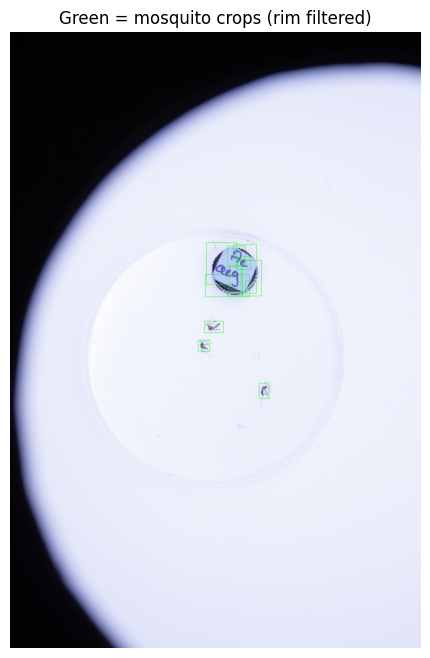

IMG_7297.jpg → kept 12 crops


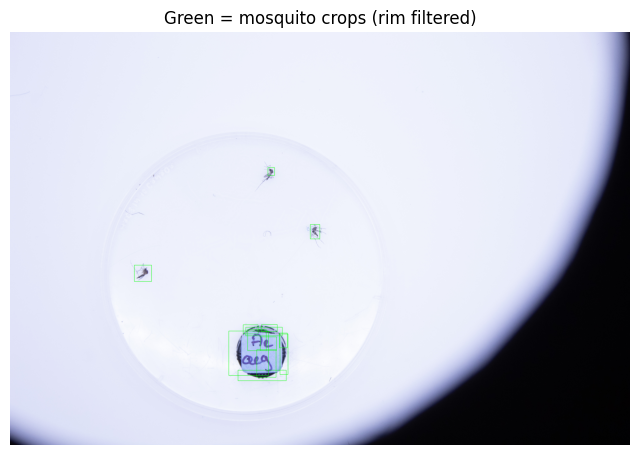

IMG_7308.jpg → kept 13 crops


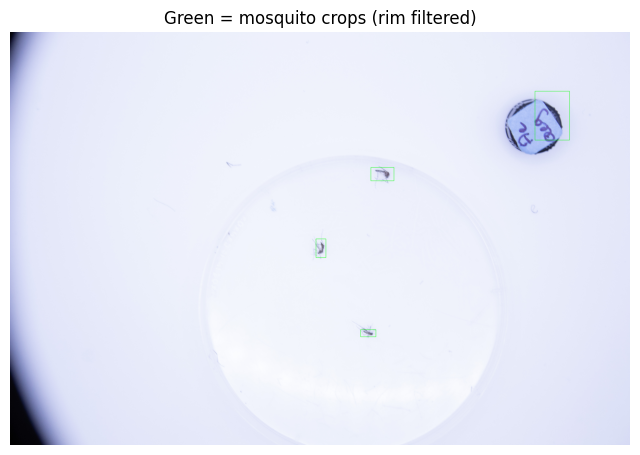

IMG_7334.jpg → kept 4 crops


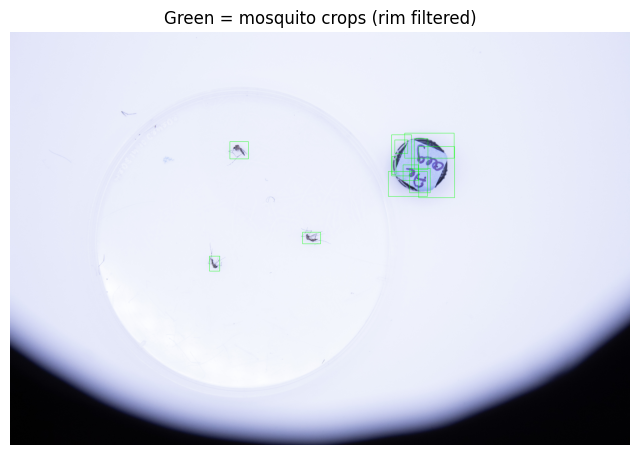

IMG_7320.jpg → kept 12 crops


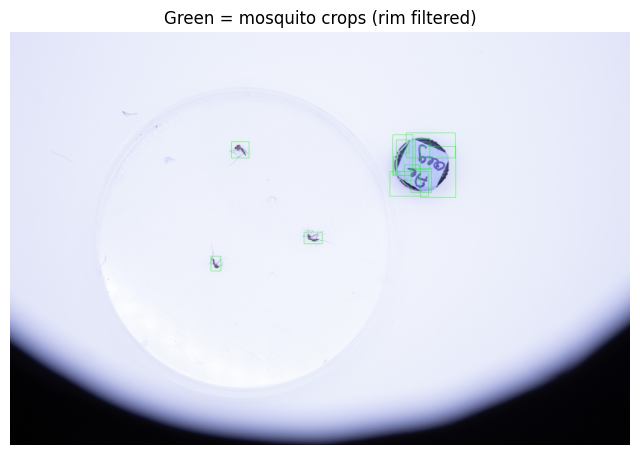

IMG_7321.jpg → kept 12 crops


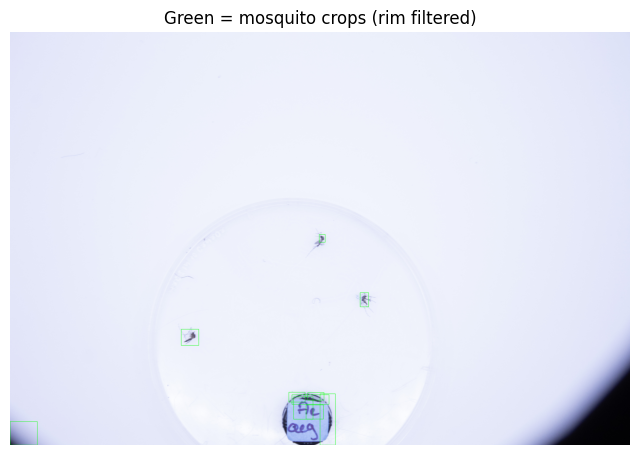

IMG_7309.jpg → kept 10 crops


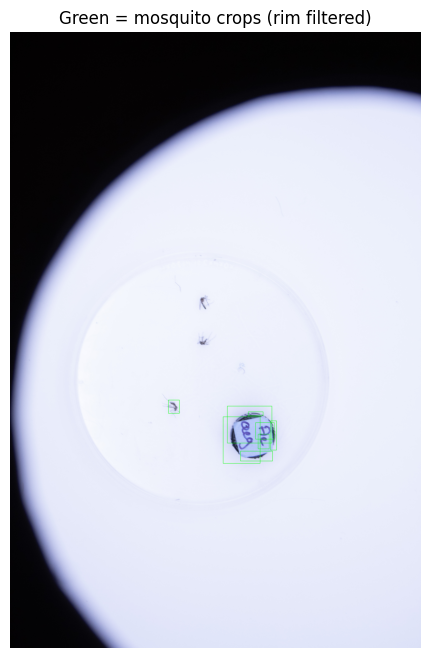

IMG_7296.jpg → kept 8 crops


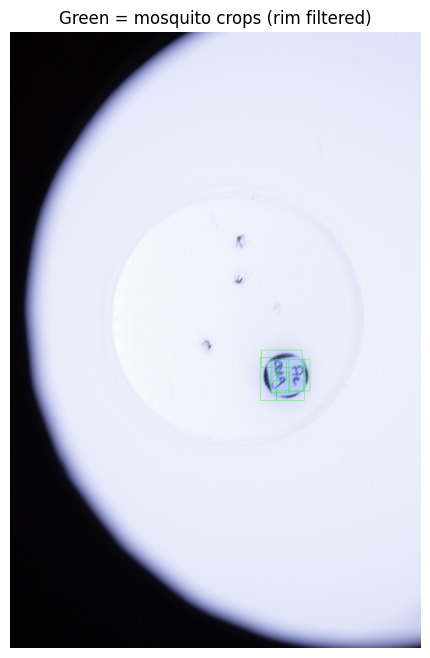

IMG_7294.jpg → kept 7 crops


In [35]:
base = "Datathon Mosquito Species Images/Aedes aegypti/JPEG"
out  = "test_output_merged"

files = [f for f in os.listdir(base) if f.lower().endswith(('.jpg','.jpeg','.png'))]
for f in files[:8]:  # test only a few first!
    n = extract_mosquitoes(os.path.join(base, f), out, preview=True)
    print(f, "→ kept", n, "crops")
